# OTA Channel Impulse Response Measurements on POWDER

> Authors (alphabetical order):
> - Cassie Jeng
> - Neal Patwari
> - Aarti Singh
> - Jie Wang
> - Meles Gebreyesus Weldegebriel

January 2025, Version 0.1

This python notebook provides code to generate an IQ file with PN codes that can be transmitted between nodes on POWDER using the Shout framework and shows the channel impulse response and multipath resulting from cross-correlating the filtered received signal with the original PN code packet.

Read and follow the instructions throughout the notebook to produce plots of the cross-correlation and channel impulse response by sequentially running the code cells. Statements marked by 🛑 indicate that something needs to be completed to continue with the code!

The code is split in three steps:
1. Create an IQ file from PN codes
2. Use Shout to transmit and receive between two nodes
3. Cross-correlate the filtered received signal with the original PN code packet to observe the channel impulse response and multipath

🛑 Navigate to `File` > `Save a Copy in Drive` to make a copy of this read-only notebook in order to make edits.

🛑 The first cell imports necessary libraries for the code. You may need to uncomment the `!pip install pylfsr` line *only the first time* you run this cell if you haven't installed this module yet.

In [2]:
# Standard packages
import argparse
import sys
import os
import subprocess
import json
import datetime

# IQ Generation packages
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import lfilter

# PN Generation packages
# !pip install pylfsr ## ----- Uncomment this line to install
import pylfsr
from pylfsr import LFSR

# Other packages
import itertools
import scipy.io as sio
from scipy import signal, stats
import h5py
from matplotlib import rc
rc('xtick',labelsize=14)
rc('ytick',labelsize=14)

# 1. Create an IQ file from PN codes

PN codes are characterized by a chosen number of stages `N_stages` and the associated code length `L_codelen = 2^N_stages - 1`. They are produced using a Linear Feedback Shift Register (LFSR) which uses `taps` (specific to the chosen number of stages) and an initial `N_stages`-dimensional state vector `state`.

You will be customizing your own PN code to transmit with Shout for this experiment.

In [3]:
# IQ Generation functions

# PURPOSE: Create QPSK bits for transmit
# INPUT: inphase and quadrature bits
# OUTPUT: QPSK_bits to transmit
def Information_Transmit_r(inphase, quad):
    in_phase = np.asarray(inphase)
    quadrature = np.asarray(quad)
    QPSK_bits = np.vstack([in_phase, quadrature])
    return QPSK_bits

# PURPOSE: List allowed PN taps based on specified number of stages
# INPUT: N_stages between 7 and 11
# OUTPUT: L_codelen PN code length, ptaps allowed taps
def choose_taps(N_stages):
    L_codelen = (2 ** N_stages) - 1
    if N_stages == 7:
        ptaps = '[7,6] [7,3] [7,1]'
    elif N_stages == 8:
        ptaps = '[8,6,5,4] [8,6,5,3]'
    elif N_stages == 9:
        ptaps = '[9,5] [9,6,4,3]'
    elif N_stages == 10:
        ptaps = '[10,7] [10,3]'
    elif N_stages == 11:
        ptaps = '[11,9] [11,8,5,2]'
    else:
        ptaps = ''
    return L_codelen, ptaps

# PURPOSE: Convert input data to signal space values
# INPUT: data bits, inputVec, outputVec coding
# OUTPUT: output values from outputVec
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('ERROR in function lut: Input and Output vectors must have identical length')
        exit()
    output = np.zeros(data.shape)
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

# PURPOSE: Insert 0's between samples to oversample at OS_Rate
# INPUT: x data to oversample, OS_Rate rate to sample
# OUTPUT: x_s oversampled data
def oversample(x, OS_Rate):
    length = len(x[0])
    x_s = np.zeros((1,length*OS_Rate))
    # Fill in one out of every OS_Rate samples with the input values
    count = 0
    h = 0
    for k in range(len(x_s[0])):
        count = count + 1
        if count == OS_Rate:
            x_s[0][k] = x[0][h]
            count = 0
            h = h + 1
    return x_s

# PURPOSE: Create a Square Root Raised Cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse shape for SRRC
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    ntemp = list(range(-N*Lp, N*Lp+1))
    n = []
    for each in ntemp:
        n.append(each + math.pow(10,-9))
    # Plug into time domain formula for the SRRC pulse shape
    h = []
    coeff = 1/math.sqrt(N)
    for each in n:
        sine_term = math.sin(math.pi * each * (1-alpha) / N)
        cosine_term = math.cos(math.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = math.pi * each / N
        denom_part = 1 - math.pow(cosine_coeff, 2)
        denominator = denom_coeff * denom_part
        pulse = coeff * numerator / denominator
        h.append(pulse)
    return h

# PURPOSE: Open filename and write array to it as binary
# INPUT: data to write as binary, filename to write to
# OUTPUT: file with complex binary data
def write_complex_binary(data, filename):
    # Open filename and write array to it as binary, format is interleaved float IQ
    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename)

# PURPOSE: Load samples from binary file
# INPUT: filename to load complex binary from
# OUTPUT: samps from file
def get_samps_from_file(filename):
    # File should be in GNURadio's format, i.e., interleaved I/Q samples as float32
    samples = np.fromfile(filename, dtype= np.float32)
    samps = (samples[::2] + 1j*samples[1::2]).astype((np.complex64)) # convert to IQIQIQ
    return samps

🛑 To generate the PN code to transmit for this experiment
1. Choose and fill in a value below for `N_stages`. For the purposes of this tutorial, stick with integer values from 7 to 11. Remember that the resulting PN code length will be `L_codelen = 2^N_stages - 1`.

The variables `samples_per_chip`, `samp_rate`, and `alpha` can be adjusted to see different Channel Impulse Responses and the varying affects of multipath depending on the resolution. For example, doubling the `samp_rate` should cause the resulting peaks to be twice as narrow. You can also increase the `alpha` value to decrease the amplitude of the side lobes. Because of the limited bandwidth available to each group during class, this could be interesting to explore on your own.

In [4]:
# PN code generation

samples_per_chip = 4
samp_rate = 2500000.0
alpha = 0.25
A = math.sqrt(9/2)
Lp = 6

N_stages = 10 ### TODO ###
L_codelen, ptaps = choose_taps(N_stages)
print('Code length L = ' + str(L_codelen))
print('Valid taps to choose: ' + ptaps)

Code length L = 1023
Valid taps to choose: [10,7] [10,3]


🛑 Continue customizing the PN code
2. Choose and fill in an initial state vector `state` as a string separated by commas only for the in-phase sequence. This vector should be `N_stages`-dimensional. A typical initial state vector for a LFSR is all 0's and a 1 in the final position, or a single 1 in any position. For example, using `N_stages = 9`, you could use `0,0,0,0,0,0,0,0,1` or `0,0,0,0,0,0,0,1,0` etc.
3. Choose and fill in `taps` as a string separated by commas only for the in-phase sequence. This should be one of the allowed options printed above based on your chosen `N_stages`. For example, using `N_stages = 9`, you could use `9,5` or `9,6,4,3`.
4. Do step 2 and 3 for the quadrature sequence as well. Choose different `state` and `taps`.

Once we have the in-phase and quadrature bit sequences, we generate the QPSK bits to transmit, modulate, oversample, convolve with the SRRC pulse shape, and get the final `QPSK_samples` PN code packet.

We transmit 1024 zeros (complex values 0+i0) at the beginning so we can still get the start of the packet if the receiver starts several samples late or the receiver needs to drop a certain number of samples in order to make sure that its queue is clear from the last sampling. Then we transmit 3 copies of the PN code packet we generated so that we have the opportunity to find a clean cross-correlation match that doesn't run into noise at the beginning or end of the packet.

In [5]:
# PN code generation

# In-Phase Sequence
state = '0,0,0,0,0,0,0,0,0,1' ### TODO ###
taps = '10,7' ### TODO ###

state = state.split(',')
state = [int(s) for s in state]

taps = taps.split(',')
taps = [int(t) for t in taps]

L = LFSR(initstate=state, fpoly=taps)
pn_iSeq = L.getFullPeriod()

# Quadrature Sequence
state = '0,0,0,0,0,0,0,1,0,0' ### TODO ###
taps = '10,3' ### TODO ###

state = state.split(',')
state = [int(s) for s in state]

taps = taps.split(',')
taps = [int(t) for t in taps]

L = LFSR(initstate=state, fpoly=taps)
pn_qSeq = L.getFullPeriod()

# ----- Uncomment if you want to see the PN code bit sequences
# print('\nPN In-Phase Sequence:\n',pn_iSeq)
# print('\nPN Quadrature Sequence:\n',pn_qSeq)

Frame = Information_Transmit_r(pn_iSeq, pn_qSeq)

# Modulation
# INPUT: data
# OUTPUT: modulated values, x
xI_list = []
for each in Frame[0]:
    if each == 0:
        xI_list.append(-1)
    else:
        xI_list.append(1)

xQ_list = []
for each in Frame[1]:
    if each == 0:
        xQ_list.append(-1) # -1j
    else:
        xQ_list.append(1) # 1j
xI_list_new = [i * A for i in xI_list]
xQ_list_new = [i * A for i in xQ_list]

xI = np.array(xI_list_new)
xQ = np.array(xQ_list_new)

xI = xI.reshape((1,len(Frame[0])))
xQ = xQ.reshape((1,len(Frame[1])))

# Oversample
# INPUT: modulated values, x
# OUTPUT: modulated values at sampling rate, samples_per_chip
x_s_I = oversample(xI,samples_per_chip)
x_s_Q = oversample(xQ,samples_per_chip)

pulse = SRRC(alpha,samples_per_chip,Lp)
pulse = np.array(pulse)
pulse = np.reshape(pulse,pulse.size)

x_s_I = np.reshape(x_s_I, x_s_I.size)
x_s_Q = np.reshape(x_s_Q, x_s_Q.size)
s_0_I = np.convolve(x_s_I, pulse, mode='full')
s_0_Q = np.convolve(x_s_Q, pulse, mode='full')

# Create complex IQ values from the I and Q components
# For this tutorial we are choosing to transmit just the real I components
# QPSK_samples = s_0_I + s_0_Q*1j
QPSK_samples = s_0_I

# Transmit 3 copies of PN code packet
numPN = 3
P = len(pulse)-1
P2 = int(P/2)
oversample_PNlen = samples_per_chip*L_codelen
QPSK_samples_add = np.zeros((oversample_PNlen*numPN)+P, dtype=type(QPSK_samples[0]))

for i in range(numPN):
    QPSK_samples_add[i*oversample_PNlen:(i*oversample_PNlen)+oversample_PNlen+P] += QPSK_samples

QPSK_samples_Final = np.hstack([np.zeros(1024, dtype=type(QPSK_samples[0])),QPSK_samples_add])

🛑 Fill in a name for the IQ file to transmit as `IQ_filename`. Do not include the `.iq` extension in the name.

We then write the `QPSK_samples_Final`, 1024 zeros and 3 copies of PN code packet, to the IQ file. We can use the `get_samps_from_file` function to read these complex binary values back.

In [6]:
IQ_filename = 'CIR_tutorial_1-23' ### TODO ###
IQ_filename = IQ_filename + '.iq'
write_complex_binary(QPSK_samples_Final,IQ_filename)

# ----- Uncomment if you want to see the complex binary written to the file
# print('\n')
# print(get_samps_from_file(IQ_filename)[-150:-140])

# 2. Use Shout to Transmit and Receive Between Two Nodes

You should now have an IQ file that you can transmit between nodes on POWDER using Shout.

🛑 Navigate to the folder icon in the far left menu of this notebook. You should see a `..` folder, `sample_data` folder, and your IQ file. Hover over the IQ file, select the three vertical dots, and Download the file.

🛑 You are now going to run an experiment on POWDER using Shout
1. Reference the table on the IH4: OTA Channel Impulse Response Measurement Canvas assignment for what nodes and frequency range to use based on your group number.
2. Log in to POWDER and start a new experiment using your resources, the `shout-long-measurement` profile, d430 compute and orchestrator node types, and None dataset.
3. Run the following command on your local host terminal to copy your IQ file to your POWDER nodes. Make sure you have the terminal open in the same directory that you downloaded the IQ file to. Change `<IQ_FILENAME.iq>` to be your IQ file name and `<SSH_COMMAND>` to be the `username@node` from the SSH command column in List View of your experiment. Run this command 3 times: for the orchestrator and both nodes so that all three have the IQ file.
  * `scp <IQ_FILENAME.iq> <SSH_COMMAND>:/local/repository/shout/signal_library`
4. Open 4 new terminal windows. Run the following two commands in two of the terminals to open two orchestrator sessions. Change `<SSH_COMMAND>` to be the `username@node` for the orchestrator node.
  * `ssh -Y -p 22 -t <SSH_COMMAND> 'cd /local/repository/bin && tmux new-session -A -s shout1 &&  exec $SHELL'`
  * `ssh -Y -p 22 -t <SSH_COMMAND> 'cd /local/repository/bin && tmux new-session -A -s shout2 &&  exec $SHELL'`
5. Run the following command on each of the remaining two terminals to connect to the two non-orchestrator nodes. Change `<SSH_COMMAND>` to be the `username@node` for the two non-orchestrator nodes, separately.
  * `ssh -Y -p 22 -t <SSH_COMMAND> 'cd /local/repository/bin && tmux new-session -A -s shout &&  exec $SHELL'`
6. Download and unzip the `CIR_Shout_files.zip` from the IH4: OTA Channel Impulse Response Measurement Canvas assignment. These files are modified slightly from the defaults in this profile and for ease in this tutorial, we are going to just copy them to the experiment nodes.
  * `meascli.py` (`/local/repository/shout/meascli.py`): `useexternalclock = False` and `usetxrx = False` changed to `True`
  * `2.start_client.sh` (`/local/repository/bin/2.start_client.sh`): Added `-t -c` to `meascli.py -s` script call
  * Copy these two files to the orchestrator and both nodes using a similar `scp` command as used to copy the IQ file to all nodes previously. Make sure to note their directory locations for the nodes.
7. The `save_iq_w_tx_file.json` file needs to be modified for your experiment. Open it in your text edit of choice.
  * Change `txfreq` and `rxfreq` to be within your allocated frequency range
  * Change `txsamps` to specify your IQ file name
  * Change `txclients` and `rxclients` to have your designated nodes using the **ID** column in the experiment List View for the two non-orchestrator comp nodes.
  * Copy the `save_iq_w_tx_file.json` file to `/local/repository/etc/cmdfiles` on the orchestrator and both non-orchestrator nodes using the same `scp` command.
8. In one of the orchestrator terminal sessions, run: `./1.start_orch.sh`
9. In both non-orchestrator terminal sessions, run:
  * `sudo sysctl -w net.core.wmem_max=24862979`
  * `./2.start_client.sh`
  * Wait for the two clients to say "Waiting for command..."
10. In the second orchestrator terminal session, run: `./3.run_cmd.sh`
11. After data collection finishes and the second orchestrator returns to the command prompt, run `ls /local/data` to check that there is a new Shout data folder.
  * Run this command on your local machine to copy the data folder: `scp -r <SSH_COMMAND>:/local/data/<SHOUT_DATA_FOLDER> .` where `<SSH_COMMAND>` is for the orchestrator and `<SHOUT_DATA_FOLDER>` is the new data folder currently on the orchestrator.
12. On your local host, zip the Shout data folder. Then navigate back to the folder icon in the left menu of this notebook. Upload the Shout data folder zip by clicking the first icon (paper with up arrow). Fill in the unzip command below with the name of your Shout data folder zip to unzip the data you just collected.

In [7]:
!unzip Shout_meas_01-23-2025_10-37-50.zip ### TODO ###

Archive:  Shout_meas_01-23-2025_10-37-50.zip
   creating: Shout_meas_01-23-2025_10-37-50/
  inflating: __MACOSX/._Shout_meas_01-23-2025_10-37-50  
 extracting: Shout_meas_01-23-2025_10-37-50/log  
  inflating: Shout_meas_01-23-2025_10-37-50/save_iq_w_tx_file.json  
  inflating: Shout_meas_01-23-2025_10-37-50/measurements.hdf5  


# Cross-Correlation and Channel Impulse Response from Collected Data

Load the data collected using Shout and cross-correlate the filtered received signal with the original `QPSK_samples` PN code packet.

In [8]:
# Reading data functions

# PURPOSE: Get data and time from timestamp
# INPUT: timestamp
# OUTPUT: data and time, example: 01-04-2023, 19:50:27
def get_time_string(timestamp):
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

# PURPOSE: Load parameters from the saved json file
# INPUT: data folder, saved json_file
# OUTPUT: experiment specifications from json file
def JsonLoad(folder, json_file):
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']
    return rxrepeat, rxrate, txnodes, rxnodes

# PURPOSE: Load data from hdf5 format measurement file
# INPUT: meas_folder path to measurement folder
# OUTPUT: data, noise, and txrxloc node names
def traverse_dataset(meas_folder):
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r")
    for cmd in dataset.keys():
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            # ----- Uncomment to see time stamps
            # print('Time Collected:', get_time_string(cmd_time))
            # print('Command meta data:', list(dataset[cmd][cmd_time].attrs.items()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            # ----- Uncomment to see time stamps
            # print('Time Collected:', get_time_string(cmd_time))
            # print('Command meta data:', list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            samplesNotx = dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))
        else:
            print('Unsupported command: ', cmd)
    return data, noise, txrxloc

🛑 Fill in the `folder` name as the name of the unzipped uploaded Shout data collection folder.

We are reading the measurement data from the experiment into this notebook.

In [9]:
# Access JSON information

folder = 'Shout_meas_01-23-2025_10-37-50' ### TODO ###

jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)

# Load data from the HDF5 file, save IQ sample arrays
rx_data, _, txrxloc = traverse_dataset(folder)

rx_names = []
for txl in txlocs:
    rx_names.append(txl.split('-')[1])

rx_names = sorted(rx_names)
print('\n ----- node names ----- ')
print(rx_names)


 ----- node names ----- 
['browning', 'meb']


In [17]:
# CIR functions

# PURPOSE: Cross-correlate received signal with transmitted signal.
#          Highest amplitude corresponds to the index delay where the
#          transmitted packet is found in the received packet.
# INPUT: rx0 received signal, packetSignal transmitted PN code packet
# OUTPUT: lagIndex highest correlation delay index, lags, xcorr_mag, peak
def crossCorrelationMax(rx0, packetSignal):
    # Cross correlate with the original packet to find it in the noisy signal
    lags = signal.correlation_lags(len(rx0), len(packetSignal), mode='same')
    xcorr_out = signal.correlate(rx0, packetSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)

    length_of_packet = len(packetSignal)
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]
    peak = lags[np.argmax(xcorr_mag)]

    plt.figure()
    plt.plot(lags, xcorr_mag, label='|X-Correlation|')
    plt.legend()
    plt.plot(peak, xcorr_mag[peak], 'xr')
    plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
    plt.xlabel('RX Packet Sample Index', fontsize=14)
    plt.tight_layout()
    plt.show()

    return lagIndex, lags, xcorr_mag, peak

# PURPOSE: Convert samples to microseconds
# INPUT: value in samples
# OUTPUT: time value in microseconds (us)
def samples_to_us(value, samp_rate):
    return (float)((value/samp_rate)*1000000)

1. For each node and each repetition (total number of repetitions per node specified by `rxrepeat` in the json file), we filter the received signal and then cross-correlate it with the original PN code packet `QPSK_samples` which was transmitted three times with the 1024 zeros.
  * The `filtered_rx0_list` saves the `filtered_rx0` for each repetition so we can access them individually later without have to run through the nested for loops again.
2. The `crossCorrelationMax` function returns the delay from the start of the received signal to where the first copy of the PN code packet was detected, representing the channel delay/lag.
3. We plot the cross-correlation results where the peak is at the delay index, `lagIndex`. The red x denotes the index where the largest peak was detected. There might be other peaks where other copies of the PN code packet were detected, depending on your chosen PN code length from the beginning of the experiment.

We can see in the plots that the noise amplitude around the peaks is less than 10% of the amplitude of the peak. There should also be small region immediately on either side of all the peaks where there are no side lobes.

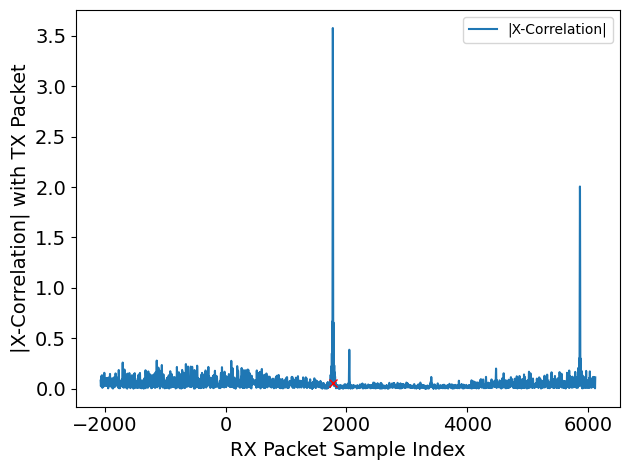

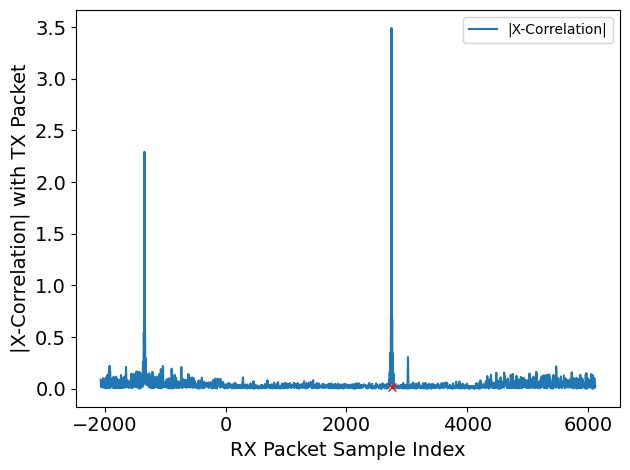

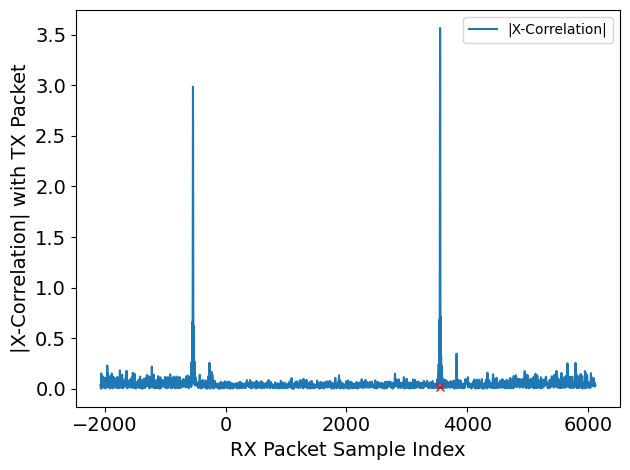

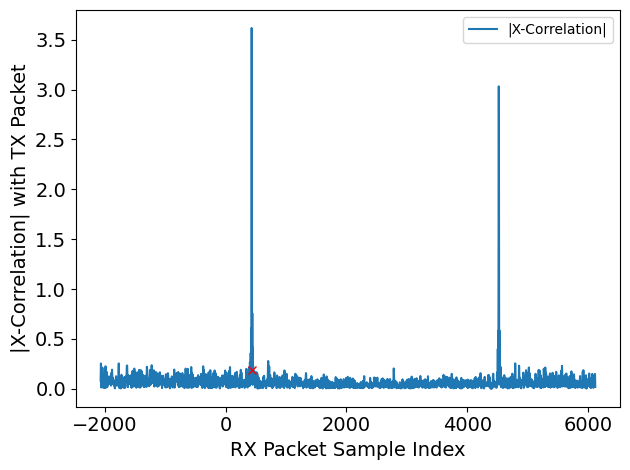

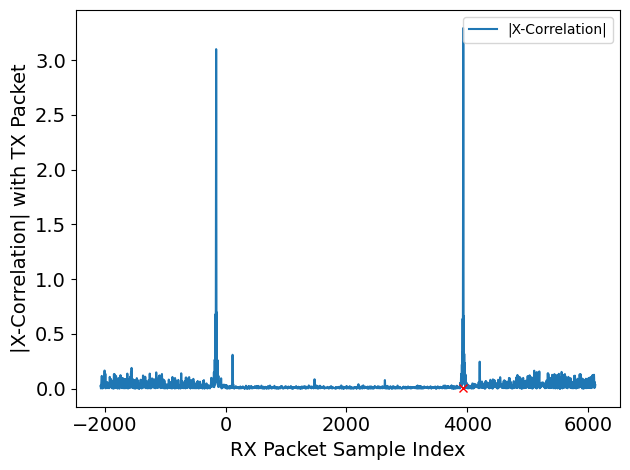

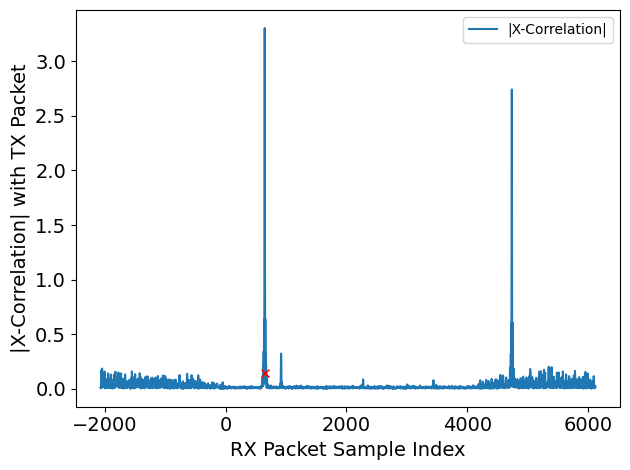

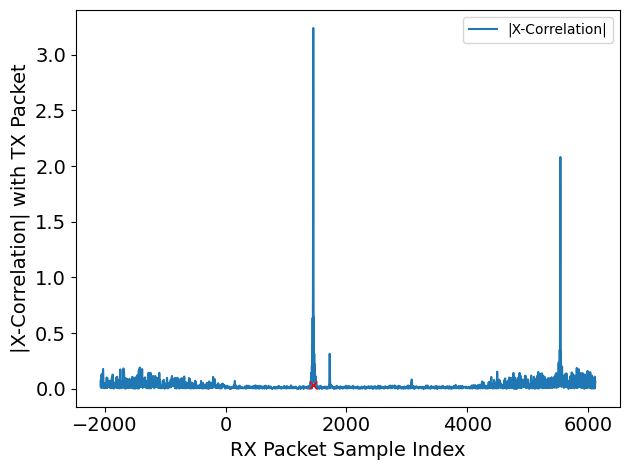

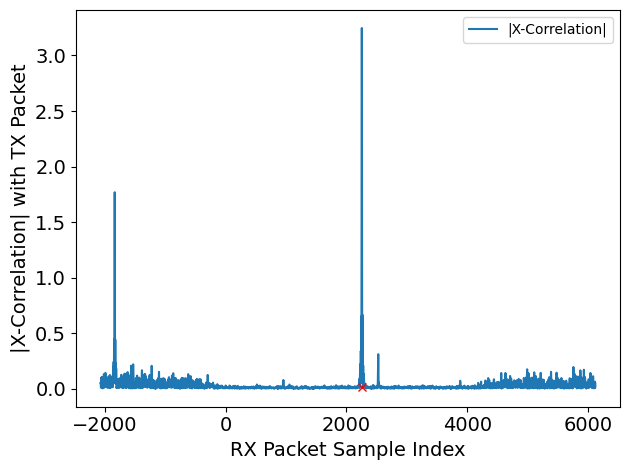

In [11]:
# Cross Correlation & Delays

filtered_rx0_list = []

for tx in txlocs:
    for rx in txlocs:
        if tx != rx:
            for repNum in range(rxrepeat):
                txloc = tx
                rxloc = rx

                rx_data[txloc] = np.vstack(rx_data[txloc])
                rxloc_arr = np.array(txrxloc[txloc])
                rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]

                # Low Pass Filtering to out_of_band frequency components
                stopband_attenuation = 60.0
                transition_bandwidth = 0.05
                cutoff_norm = 0.15
                filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
                taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
                filtered_rx0 = signal.lfilter(taps, 1.0, rx0)
                filtered_rx0_list.append(filtered_rx0)

                # packetSignal = get_samps_from_file(IQ_filename)
                packetSignal = QPSK_samples
                lagIndex, lags, xcorr_mag, peak = crossCorrelationMax(filtered_rx0, packetSignal)
                # lagIndex = crossCorrelationMax(QPSK_samples_Final, packetSignal)

🛑 To take a closer look at the multipath and channel impulse response seen from the cross-correlation, choose one plot (any repetition of any transmitter/receiver) from the collection displayed above. Note it's "index" `plotnum` based on the order it was displayed. For example, if you choose the second plot shown above, the "index" is `plotnum = 1`. Fill in `plotnum` below.

We rerun the cross-correlation for your chosen repetition to isolate the chosen plot and data. The max peak `lagIndex` is displayed. This should be a good choice of peak to look at further, but if you would like to choose a different clean peak in the plot, adjust the lagIndex as needed for the second plot below.

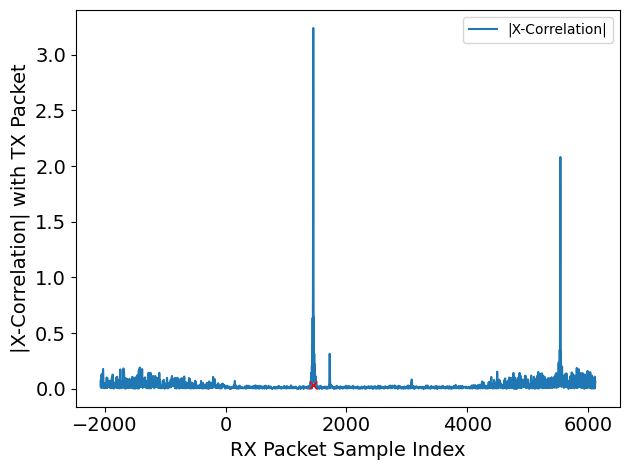

RX Time Delay: 1451


In [15]:
# Look closer at Cross-Correlation Peak

plotnum = 6 ### TODO ###
filtered_rx0 = filtered_rx0_list[plotnum]

lagIndex, lags, xcorr_mag, peak = crossCorrelationMax(filtered_rx0, QPSK_samples)
print('RX Time Delay: ' + str(lagIndex))

# Change lagIndex if a different peak is desired to analyze in zoomed plot

🛑 Choose a number of samples `samps_around` to specify how many samples before and after the peak to include in the zoomed plot. A good number to start for this is around 50 samples, but you can mess around with different numbers to zoom in and out on the plot.

  * Below we plot the same cross-correlation plot but focused on the peak/index where we found the first copy of the transmitted PN code packet in the received signal.
  * You should be able to see the side lobes around the peak that are a result of using the SRRC pulse shape.
  * This is the voltage plot. To see the power plot, you can plot `20*np.log10(xcorr_mag)` instead. In the power plot, you should see about 30 dB of dynamic range around the peak.
  * You can also uncomment the code below to plot the cross-correlation against time in microseconds instead of samples.

🛑 Turn in this zoomed in plot for the in-class activity IH4: OTA Channel Impulse Response Measurement assignment on Canvas.

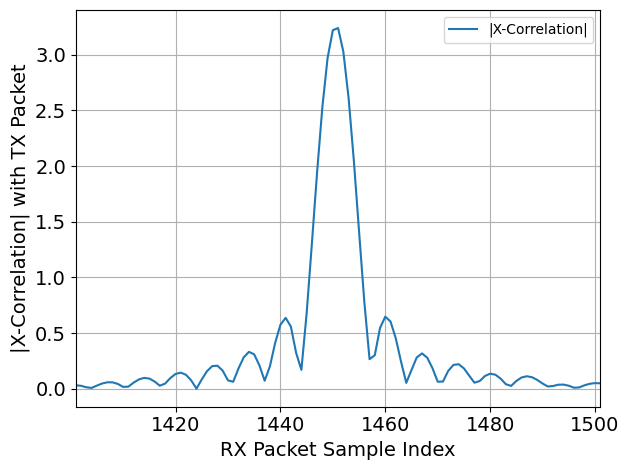

In [21]:
# Zoom in on Cross-Correlation Peak

samps_around = 50 ### TODO ###

before_peak = lagIndex - samps_around
after_peak = lagIndex + samps_around

plt.figure()
plt.plot(lags, xcorr_mag, label='|X-Correlation|')
plt.legend()
plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
plt.xlabel('RX Packet Sample Index', fontsize=14)
plt.xlim((before_peak,after_peak))
plt.tight_layout()
plt.grid(True)
plt.show()

# -- Uncomment to plot against time in microseconds rather than samples
# plt.figure()
# plt.plot(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
# plt.legend()
# plt.ylabel('|X-Correlation| with TX Packet', fontsize=14)
# plt.xlabel('Time (us)', fontsize=14)
# plt.xlim((samples_to_us(before_peak,samp_rate),samples_to_us(after_peak,samp_rate)))
# plt.tight_layout()
# plt.grid(True)
# plt.show()